### Test working method

(452, 996, 1) tf.Tensor([54], shape=(1,), dtype=uint8)


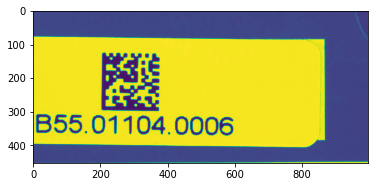

In [2]:
import matplotlib.pyplot as plt
img_path = '/data/aoi-wzs-p1-dip-fa-nvidia/data-center/D27/NG/2020-12-18/J605115MZA1_LABEL-1_180_000_000.jpg'
import tensorflow as tf
path = tf.constant(img_path)
img = tf.io.read_file(path)
img = tf.io.decode_jpeg(img, channels=1)
# img = tf.cast(img, dtype=tf.dtypes.float32) / 255.
print(img.shape, img[0,0,:])
plt.imshow(img)

(452, 996, 3) tf.Tensor([0.00012207 0.00012207 0.00017263], shape=(3,), dtype=float32)


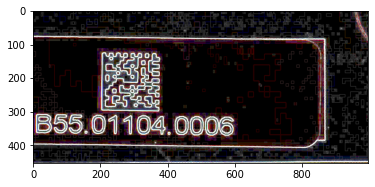

In [2]:
img_with_batch = tf.expand_dims(img, axis=0)
# aug_img = tf.image.per_image_standardization(
#     img
# )
grad_components = tf.image.sobel_edges(img_with_batch)
edg_image = tf.math.reduce_euclidean_norm(grad_components, axis=-1)
aug_img_batch = tf.clip_by_value(edg_image, 0., 1.)
# grad_mag_components = grad_components**2
# grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1) # sum all magnitude components
aug_img_batch = tf.sqrt(aug_img_batch)
aug_img = tf.squeeze(aug_img_batch, axis=0)
# aug_img = tf.image.transpose(aug_img)
print(aug_img.shape, aug_img[0,0,:])
plt.imshow(aug_img)

### Training script

In [1]:
import random
import tensorflow as tf
def to_ds_label(com, label):
    ds = tf.data.experimental.SqlDataset(
    "sqlite", "/data/robert/training/p1-dip-metadata.db", 
    f"""select path, label from metadata 
    where label = '{label}' and 
    component_class = '{com}'
    """, (tf.string, tf.string))
    return ds

LABEL_CLASS_LIST = ['NG', 'OK']
label_lookup = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(LABEL_CLASS_LIST, tf.constant([0, 1], dtype=tf.int64)), -1)
def parse_img(img):
    # img = tf.io.decode_image(img, channels=all_var_dict['target_shape'][-1], 
    #                             dtype=tf.dtypes.float32, expand_animations = False)
    img = tf.io.decode_jpeg(img,channels=3,dct_method='INTEGER_ACCURATE',try_recover_truncated=True)
    img = tf.cast(img, dtype=tf.dtypes.float32) / 255.0
    img = tf.image.resize_with_pad(img, 224, 224)
    return img

def random_aug_parse_img(x, p=0.5):
    x = tf.io.decode_jpeg(x,channels=3,dct_method='INTEGER_ACCURATE',try_recover_truncated=True)
    x = tf.cast(x, dtype=tf.dtypes.float32) / 255.0
    img_with_batch = tf.expand_dims(x, axis=0)
    grad_components = tf.image.sobel_edges(img_with_batch)
    edg_image = tf.math.reduce_euclidean_norm(grad_components, axis=-1)
    grad_mag_square = tf.clip_by_value(edg_image, 0., 1.)
    x = tf.squeeze(grad_mag_square, axis=[0]) # this is the image tensor you want
    if tf.random.uniform([]) < p:
#         if tf.random.uniform([]) < p:
#             x = tf.image.rgb_to_grayscale(x)
#             x = tf.squeeze(x, axis=-1)
#             x = tf.stack([x, x, x], axis=-1)
        x = tf.image.random_jpeg_quality(x, 0, 100)
        if tf.random.uniform([]) < p:
            x = tf.image.flip_left_right(x)
        if tf.random.uniform([]) < p:
            x = tf.image.adjust_saturation(x, random.uniform(0, 1) * 3) # 0-3
        if tf.random.uniform([]) < p:
            x = tf.image.adjust_brightness(x, random.uniform(0, 1) / 2) # 0-0.5
#         if tf.random.uniform([]) < p:
#             x = tf.image.central_crop(x, central_fraction=(random.uniform(0, 1) + 1 ) / 2) #0.5-1
    x = tf.image.resize_with_crop_or_pad(x, 224, 224)
    return x

def label_to_onehot(label):
    label = label_lookup.lookup(label)
    label = tf.one_hot(label, len(LABEL_CLASS_LIST))
    # label = tf.cast(label, dtype=tf.float32)
    return label

def parse_func_with_aug(path, label):
    features = {
        'image': random_aug_parse_img(tf.io.read_file(path)),
#         'label': label_to_onehot(label),
    }
    label = label_to_onehot(label)
    return features, label

def parse_func(path, label):
    features = {
        'image': parse_img(tf.io.read_file(path)),
#         'label': label_to_onehot(label),
    }
    label = label_to_onehot(label)
    return features, label

def parse_example_to_path_label(example_proto):    
    image_feature_description = {
        "path": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "degree": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    features_in_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return features_in_example["path"], features_in_example["label"]

In [2]:
path_ds = []
for l in LABEL_CLASS_LIST:
    path_ds.append(to_ds_label('screw',l))
path_ds

[<SqlDatasetV2 shapes: ((), ()), types: (tf.string, tf.string)>,
 <SqlDatasetV2 shapes: ((), ()), types: (tf.string, tf.string)>]

In [3]:
tfds = tf.data.TFRecordDataset('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/other_comps_random_1w.tfrecord')
tfds = tfds.map(parse_example_to_path_label, tf.data.experimental.AUTOTUNE)
print(tfds, next(iter(tfds)))

<ParallelMapDataset shapes: ((), ()), types: (tf.string, tf.string)> (<tf.Tensor: shape=(), dtype=string, numpy=b'/data/aoi-wzs-p1-dip-fa-nvidia/data-center/D4/OK/2020-08-31/CN0YTVTTWS30008T00DIA07_KJ3_000_000_000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'NG'>)


In [4]:
path_ds.append(tfds)
path_ds

[<SqlDatasetV2 shapes: ((), ()), types: (tf.string, tf.string)>,
 <SqlDatasetV2 shapes: ((), ()), types: (tf.string, tf.string)>,
 <ParallelMapDataset shapes: ((), ()), types: (tf.string, tf.string)>]

## split to train, valid

In [5]:
def split_to_train_valid(ds, ratio):
    amount = [i for i,_ in enumerate(ds)][-1] + 1
    amount_to_take = int(amount * ratio)
    shuffle_ds = ds.shuffle(amount)
    return shuffle_ds.take(amount_to_take), shuffle_ds.skip(amount_to_take)

def prepare_ds(ds_list, ratio=0.5, shuffle=1000, batch_size=64, aug=True, cache=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_ds_list = []
    for i in range(len(path_ds)):
        splitted_take_ds, splitted_skip_ds = split_to_train_valid(path_ds[i], ratio)
        train_ds_list.append(splitted_take_ds.repeat())
        if i==0:
            valid_ds = splitted_skip_ds
        else:
            valid_ds = valid_ds.concatenate(splitted_skip_ds)
        print([i for i,_ in enumerate(valid_ds)][-1] + 1)
    train_ds = tf.data.experimental.sample_from_datasets(train_ds_list)
    if aug:
        train_ds = train_ds.shuffle(shuffle).map(parse_func_with_aug, num_parallel_calls=AUTOTUNE)
    else:
        train_ds = train_ds.shuffle(shuffle).map(parse_func, num_parallel_calls=AUTOTUNE)
    if cache:
        train_ds = train_ds.repeat().cache().batch(batch_size).prefetch(AUTOTUNE)
    else:
        train_ds = train_ds.repeat().batch(batch_size).prefetch(AUTOTUNE)
    valid_ds = valid_ds.map(parse_func, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return train_ds, valid_ds

In [6]:
train_ds, valid_ds = prepare_ds(path_ds)

72
2851
7851


### model

In [9]:
ly = tf.keras.layers
inputs = {
        'image': tf.keras.Input((224, 224, 3), name='image'),
  }
x = inputs['image']
model_body = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False, weights='/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/LABEL/label_M2_18402_5e-7_ep_118-vl_0.0026-va_0.9996.h5')
for layer in model_body.layers:
    layer.trainable = True
x = model_body(x)
x = ly.GlobalAveragePooling2D()(x)
x = ly.Dense(128, name='dense_128')(x)
x = ly.Dense(2, name='dense_logits')(x)
x = ly.Activation('softmax', dtype='float32', name='predictions')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

ValueError: You are trying to load a weight file containing 3 layers into a model with 104 layers.

In [14]:
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
METRICS = [
            tf.keras.metrics.CategoricalAccuracy(name='acc'),
            tf.keras.metrics.Precision(name="precision/ok", class_id=1),
            tf.keras.metrics.Precision(name="precision/ng", class_id=0),
            tf.keras.metrics.Recall(name="recall/ok", class_id=1),
            tf.keras.metrics.Recall(name="recall/ng", class_id=0),
        ]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 10 ** -4), 
                        loss=tf.keras.losses.CategoricalCrossentropy(),  
                        metrics=METRICS)
model.fit(train_ds, epochs=10, validation_data=valid_ds, steps_per_epoch=1000, verbose=2)

Epoch 1/10
1000/1000 - 655s - loss: 0.1222 - acc: 0.9531 - precision/ok: 0.9353 - precision/ng: 0.9619 - recall/ok: 0.9240 - recall/ng: 0.9677 - val_loss: 0.6542 - val_acc: 0.6460 - val_precision/ok: 0.0000e+00 - val_precision/ng: 0.6460 - val_recall/ok: 0.0000e+00 - val_recall/ng: 1.0000
Epoch 2/10


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-41456ea339ec>", line 13, in <module>
    model.fit(train_ds, epochs=10, validation_data=valid_ds, steps_per_epoch=1000, verbose=2)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 807, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  

TypeError: object of type 'NoneType' has no len()